
Solution to Winter 2021 Data Science Intern Challenge




In [149]:

*Import dataset;
FILENAME REFFILE '/folders/myfolders/shopify/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv';

PROC IMPORT DATAFILE=REFFILE
    DBMS=CSV
    OUT=WORK.IMPORT;
    GETNAMES=YES;
RUN;

title 'Content of imported dataset';
PROC CONTENTS DATA=WORK.IMPORT; RUN;


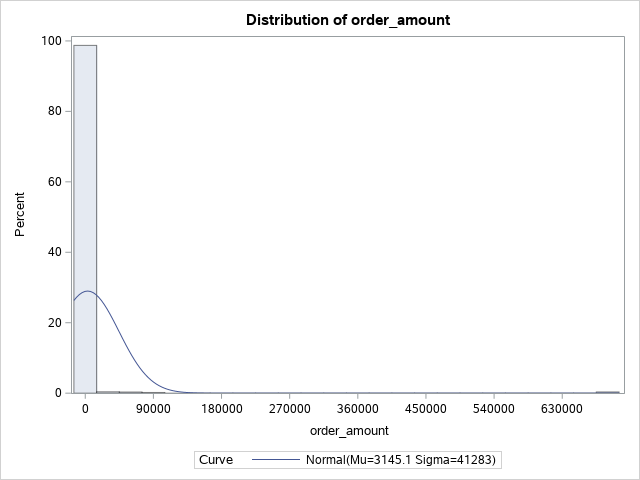
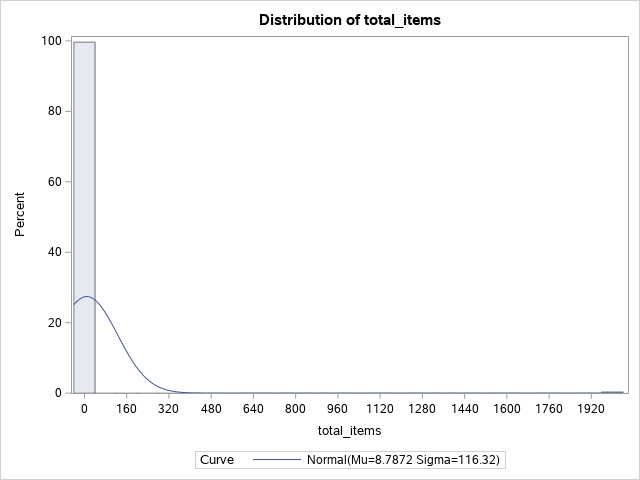
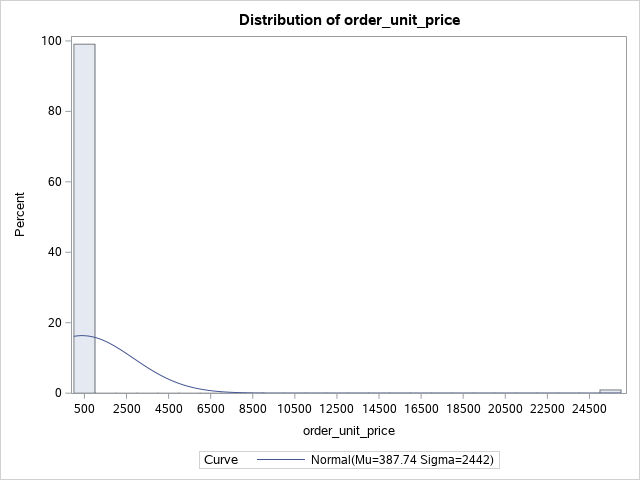

In [136]:
*Check extreme values;

*Create new variable for checking reasonable unit price for each order;
DATA work.check_extreme;
    SET work.import;
    order_unit_price = order_amount / total_items;
run;

title "Checking extreme values for each order ";
proc univariate data=work.check_extreme;
   id order_id;
   var order_amount total_items order_unit_price;
   histogram / normal; 
run; 

Q1-1:

This is largely because of extreme values. We can see from the quantitative table that:
 
The variable order_amount has an extreme value of '704000'.
The variable total_items has an extreme value of '2000'.
And the extreme value of order_unit_price is '25725'.
While 99% of the values of these variables are less than these numbers.

We can go back to the order information:

The order_amount with '704000'and total_items with '2000' are both from 
the same shop (shop_id: 42) and customer (user_id: 607), at same purchase time
(4 am) on each purchase day. Although their order_unit_price is 352, which is within
a reasonable range. It appears that these orders are bogus and we can ignore them. 

The orders with order_unit_price '25725', which is extremely high for a sneaker, come
from the same shop (shop_id: 78). They look like regular orders but can not represent
Sneaker Shops. We should not include these orders either.



In [88]:
*Then let's remove extreme orders and calculate the AOV again;

title 'Avergae Order Value of Sneaker Shops on MARCH';
PROC SQL;
    SELECT SUM(order_amount) / COUNT(*) as AOV format=dollar4., COUNT(*) as Orders
    FROM
        (
        SELECT * 
        FROM work.check_extreme 
        WHERE order_amount ne 704000 and total_items ne 2000 and 
        order_unit_price ne 25725
        );
QUIT;

AOV,Orders
$303,4937


Q1-1:

After removing the orders with extreme values, we get the new AOV from 4937 orders on March for Sneaker Shops - $303.

So, let's take a look at each sneaker shop's AOV, and how they are distribute around the mean.


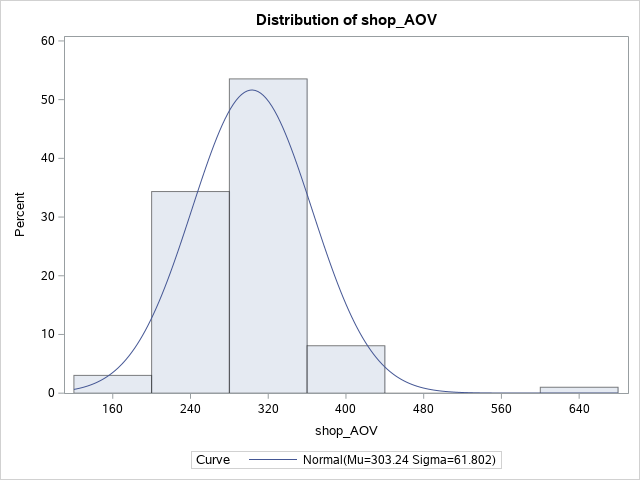

In [139]:
* Excude the shops with extreme values, then calculate AOV for each shop;

PROC SQL;
    CREATE TABLE import_exclude AS
    SELECT * 
        FROM work.check_extreme 
        WHERE order_amount ne 704000 and total_items ne 2000 and 
        order_unit_price ne 25725;
        
    CREATE TABLE shop_AOV AS
    SELECT shop_id, 
           SUM(order_amount) AS sales,
           COUNT(order_id) AS orders,
           SUM(order_amount) / COUNT(order_id) AS shop_AOV
    FROM import_exclude
    GROUP BY shop_id
    ORDER BY 4 DESC;
QUIT;


title "Checking Distribution for shop_AOV ";
proc univariate data=work.shop_AOV;
   var shop_AOV;
   histogram / normal; 
run; 



Q1-1:

Now, we get a whole picture of sneaker shops by looking at the AOV at shop level.

We can see that the distribution of shop_AOV is right-skewed, due to some exteme values - such as $652.235; 90% values are clustered around the mean, ranging from $214 to $384.

Then, we can conclude that 90% of sneaker shops sell from $214 to $384 per order, with the total average at $303.

But, will AOV be able to access the true performance for these stores?  Let's take a further look at each store's ranking among other stores as we consider more metrics.


In [145]:
/* Calculate each store's monthly sales, monthly orders, and also shop AOV, then group them within each metric;
The group numbers are from 0 to 4, with values in increasing order. The bigger the number, the bigger the value.*/

PROC RANK DATA = work.shop_AOV 
          OUT=work.shop_quartiles
          GROUPS = 4;
     VAR sales orders shop_AOV;
     RANKS sales_quartile orders_quartile AOV_quartile;
RUN;

title 'Shop Quartiles Table';
PROC PRINT DATA = work.shop_quartiles (obs = 20);
RUN;

Obs,shop_id,sales,orders,shop_AOV,sales_quartile,orders_quartile,AOV_quartile
1,42,22176,34,652.235,3,0,3
2,50,17756,44,403.545,3,1,3
3,90,19758,49,403.224,3,1,3
4,38,13680,35,390.857,1,0,3
5,81,22656,59,384.000,3,3,3
6,6,22627,59,383.508,3,3,3
7,89,23128,61,379.148,3,3,3
8,33,15051,40,376.275,2,0,3
9,51,16643,46,361.804,2,1,3
10,59,21538,60,358.967,3,3,3


In [148]:
* Calculate each shop's score by concatenating the quartile no. of monthly sales, orders and shop_AOV;

title 'Shop Score Table';
PROC SQL outobs=40;
    CREATE TABLE work.shop_score AS
    SELECT shop_id, sales, orders, shop_AOV, 
           cats(sales_quartile, orders_quartile, AOV_quartile) AS shop_score
    FROM work.shop_quartiles;
    SELECT * FROM work.shop_score
    ORDER BY shop_score DESC;
QUIT;


shop_id,sales,orders,shop_AOV,shop_score
73,19470,58,335.6897,333
59,21538,60,358.9667,333
89,23128,61,379.1475,333
70,20241,59,343.0678,333
13,21760,63,345.3968,333
81,22656,59,384,333
84,20196,59,342.3051,333
6,22627,59,383.5085,333
71,21320,66,323.0303,332
43,19367,58,333.9138,332


Q1-2:
With AOV alone, we can't fully measure the store's sales performance. 
Although we removed the extremes, which had the greatest impact on AOV, 
it's still difficult to measure the overall magnitude of the store and the stage it's at 
and give recommendations for improvement based on AOV alone. 

Thus, the combined metric of sales, orders and AOV is a better way to evaluate the overall sales of sneaker shops.

Q1-3:

Obviously, some of the high sales are due to high AOV and some are due to high order volume at low price. 
Some stores with high AOV still have the potential to accelerate sales by increasing order volume.
Some stores with very low AOV, on the other hand, will have to consider whether to maintain a low price 
strategy or enhance the uniqueness of their products to increase AOV. 

Depending on the strategy and stage, we can segment these stores and give them some advice based on their performance.
Examples are given as below:

TOP shops -- shops with '333' score which have high volumes of sales, orders as well as AOV.  
These stores can be identified as the top performing stores for their own abilities. 
They have a stable customer base and a recognizable brand. 
They should maintain the effort and think about launching customer loyalty program.

Need increasing orders -- the shops with high sales and AOV ，but low orders，such as '303','313', and '323'.
It can be seen that the high AOV is the major contributor to sales performance, and there is room for improvement
in order intake. These stores will benefit from  cross-selling and more promotional programs.

Need increasing Brand Value -- the shops with very high orders but low AOV and still low sales, 
such as '231','130','030' and so on, they should revisit the Low Price Strategy, raise the brand value 
and try up-selling program to target customers.


In [ ]:
Q2-1:How many orders were shipped by Speedy Express in total? 

Answer: 54

SELECT s.shippername,
       COUNT(o.orderid) orders_of_shipper
FROM shippers s
INNER JOIN orders o ON s.shipperid=o.shipperid
WHERE s.shippername = 'Speedy Express';



In [ ]:
Q2-2: What is the last name of the employee with the most orders? 

Answer: Peacock

SELECT e.EmployeeID, COUNT(*) orders, e.lastname
FROM Orders o
INNER JOIN employees e ON o.EmployeeID = e.EmployeeID
GROUP BY 1
ORDER BY 2 DESC;


In [ ]:
Q2-3: What product was ordered the most by customers in Germany? 

Answer: Gorgonzola Telino

SELECT 
    p.productname, 
    count(*) orders
FROM customers c 
INNER JOIN orders o ON o.customerID = c.customerID
INNER JOIN orderdetails od ON o.orderID = od.orderID
INNER JOIN products p ON od.productID = p.productID
WHERE c.country = 'Germany'
group by 1
ORDER BY 2 DESC;
